In [18]:
from timeit import default_timer
start = default_timer()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')



In [19]:
def explode(df, lst_cols, fill_value=''):
    # make sure `lst_cols` is a list
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)

    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()

    if (lens > 0).all():
        # ALL lists in cells aren't empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        # at least one list in cells is empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]
    
def get_months(d, base_year=2000):
    return (d.year - base_year)*12 + d.month

interesting_genres = ['Animation', 'Horror', 'Drama', 'Adventure', 'Romance', 'Crime', 'Thriller']
#interesting_genres = [ 'Horror', 'Drama']
            

In [20]:
st = default_timer()
# First time data load.
#movies = pd.read_csv('../data/ml-100km/movies.csv', sep=',', names = ['movieId','title','genres'], engine='python', skiprows=1)
#ratings = pd.read_csv('../data/ml-100k/ratings.csv', sep=',', names = ['userId','movieId','rating','timestamp'], engine='python', skiprows=1)
movies = pd.read_csv('../data/ml-1m/movies.dat', sep='::', names = ['movieId','title','genres'], engine='python')
ratings = pd.read_csv('../data/ml-1m/ratings.dat', sep='::', names = ['userId','movieId','rating','timestamp'], engine='python')
print(movies.dtypes)
print(ratings.dtypes)

print(movies.head())
print(ratings.head())


print('Exploding genres of movies')
movies.genres = movies.genres.str.split('|')
movies = explode(movies, ['genres'])
print(movies.dtypes)
print(movies.head())


print('Altering timestamps in ratings to get months')
ratings['timestamp'] = pd.to_datetime(ratings.timestamp, unit='s')
ratings['timestamp'] = ratings['timestamp'].map(get_months)

print(ratings.dtypes)
print(ratings.head())

movies = movies.drop('title', axis=1)
print(ratings.dtypes)
print(movies.head())

print('Merging ratings and movies')
ratings = ratings.merge(movies, left_on='movieId', right_on='movieId', how='inner')
ratings.head()

print('Avg movie rating = ', np.mean(ratings['rating']))

movieId     int64
title      object
genres     object
dtype: object
userId       int64
movieId      int64
rating       int64
timestamp    int64
dtype: object
   movieId                               title                        genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy
   userId  movieId  rating  timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291
Exploding genres of movies
movieId     int64
title      object
genres     object
dtype: object
   movieId             title      genres
0        1  Toy 

(1024905, 5)
   month     genres    rating
0      4  Adventure  3.468177
1      4  Animation  3.680525
2      4      Crime  3.700456
3      4      Drama  3.707098
4      4     Horror  3.300000
Std head printing
   Month     genres    rating
0      4  Adventure  1.099385
1      4  Animation  0.988261
2      4      Crime  1.022116
3      4      Drama  1.016764
4      4     Horror  1.156709


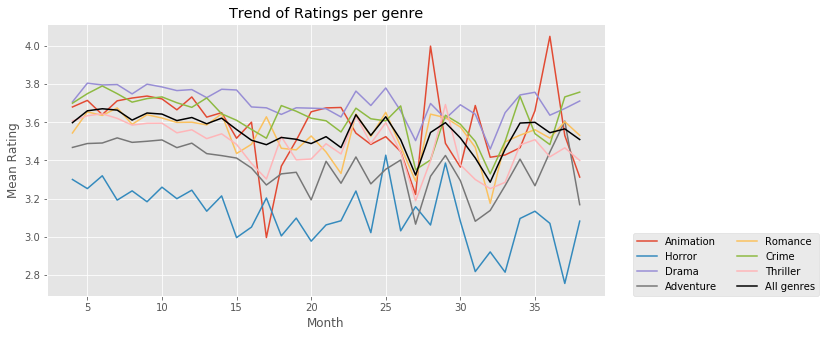

In [21]:
ratings = ratings.loc[ratings['genres'].isin(interesting_genres)]
print(ratings.shape)
mean_ratings = ratings.groupby(['timestamp', 'genres'], as_index=False)['rating'].aggregate(np.mean)
#mean_ratings = ratings.groupby(['timestamp', 'genres'])['rating'].aggregate(np.mean).reset_index()
#print('printing the group')
#for name in mean_ratings:
#    print(name)
#    print(group)
mean_ratings.rename(columns={'timestamp': 'month'}, inplace=True)


print(mean_ratings.head())

print('Std head printing')

sd_ratings = ratings.groupby(['timestamp', 'genres'])['rating'].aggregate(np.std).reset_index()
sd_ratings.rename(columns={'timestamp': 'Month'}, inplace=True)
print(sd_ratings.head())


fig = plt.figure(figsize=(10,5))
#ax = fig.add_axes([0.1, 0.1, 0.0, 0.75])
ax = fig.add_subplot(111)

#ax.set_ylim(2, 5)
#ax.margins(x=-0.1, y=-0.4)
for genr in interesting_genres:
    tmp_data = mean_ratings.loc[mean_ratings['genres'].isin([genr])]
    tmp_sd = sd_ratings.loc[sd_ratings['genres'].isin([genr])]
    ax.plot(tmp_data.month, tmp_data.rating, label=genr, alpha=1.0)
    #ax.errorbar(tmp_data.month, tmp_data.rating, (tmp_sd['rating']/2),fmt='o', label=genr)


mean_ratings_all_genres = ratings.groupby(['timestamp'], as_index=False)['rating'].aggregate(np.mean)
sd_ratings_all_genres = ratings.groupby(['timestamp'])['rating'].aggregate(np.std).reset_index()
#print('sd all genr printing')
#print(sd_ratings_all_genres)
mean_ratings_all_genres.rename(columns={'timestamp': 'month'}, inplace=True)
#print(mean_ratings_all_genres.head())
ax.plot(mean_ratings_all_genres.month, mean_ratings_all_genres.rating, "-", label='All genres', color='black')

#plt.ylim(2,)
plt.xlabel('Month')
plt.ylabel('Mean Rating')
plt.title('Trend of Ratings per genre')
#plt.legend(loc='lower right')
plt.legend(loc=(1.05,0), ncol=2)
#plt.ylim(0,)



In [22]:
#ratings2 = ratings.groupby(['movieId', 'timestamp', 'genres'], as_index=False)['rating'].aggregate(np.mean)
#ratings2.head()
#plt.plot(ratings2)